In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.utils import plot_model

## Prepare the data

In [25]:
# Dataset Parameters
root = './dataset/'
batch_size = 44
img_height = 256
img_width = 256
seed = np.random.randint(0, 128)

In [26]:
# importing the training split
train_ds = keras.utils.image_dataset_from_directory(
  root + 'train/',
  validation_split=None,
  seed=seed,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15928 files belonging to 23 classes.


In [27]:
# importing the validation split
val_ds = keras.utils.image_dataset_from_directory(
  root + 'test/',
  validation_split=None,
  seed=seed,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size/2)

Found 4228 files belonging to 23 classes.


# Hyperparameter initialisation and Dataset finalization

In [28]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [29]:
# testing for class names presence
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['Acne, or Rosacea', 'Actinic Keratosis, or other Malignant Lesions', 'Alopecia, or other Hair Diseases', 'Atopic Dermatitis', 'Bacterial Infections', 'Benign Tumors', 'Bullous Disease', 'Connective Tissue Diseases', 'Eczema', 'Exanthems, or Drug Eruptions', 'Fungal Infections', 'Healthy or Benign growth', 'Herpes, HPV, other STDs', 'Lyme Diseasem, Infestations and Bites', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus or other Nail Disease', 'Poison Ivy or Contact Dermatitis', 'Psoriasis, Lichen Planus or related diseases', 'Systemic Disease', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts, or other Viral Infections']
23


In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(44, 256, 256, 3)
(44, 23)


In [31]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


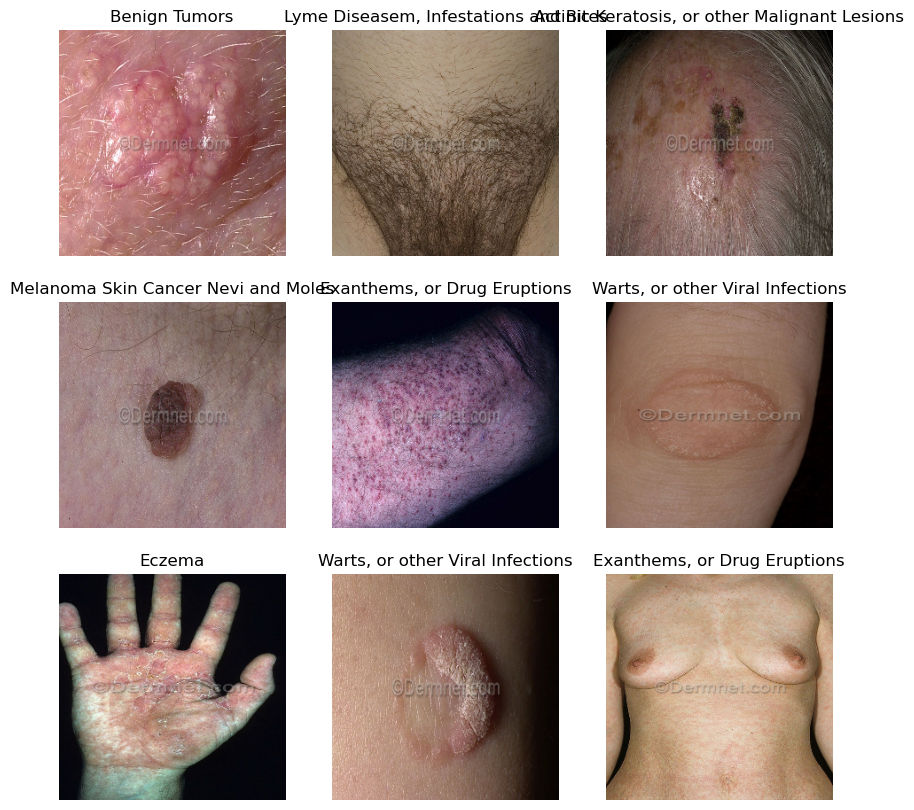

In [32]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = np.argmax(label_batch[i])
  plt.title(class_names[label])
  plt.axis("off")

In [33]:
%reload_ext tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [64]:
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, val=True):
        super().__init__()
        self.val = val
        
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(21,7))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if self.val:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_'+metric], 
                            label='validation '+metric)
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [66]:
# Define an EarlyStopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    min_delta=0.0125,            # Minimum change in accuracy to be considered an improvement
    patience=5,               # Number of epochs with no improvement to stop training
    restore_best_weights=True  # Restore model weights to the best checkpoint
)

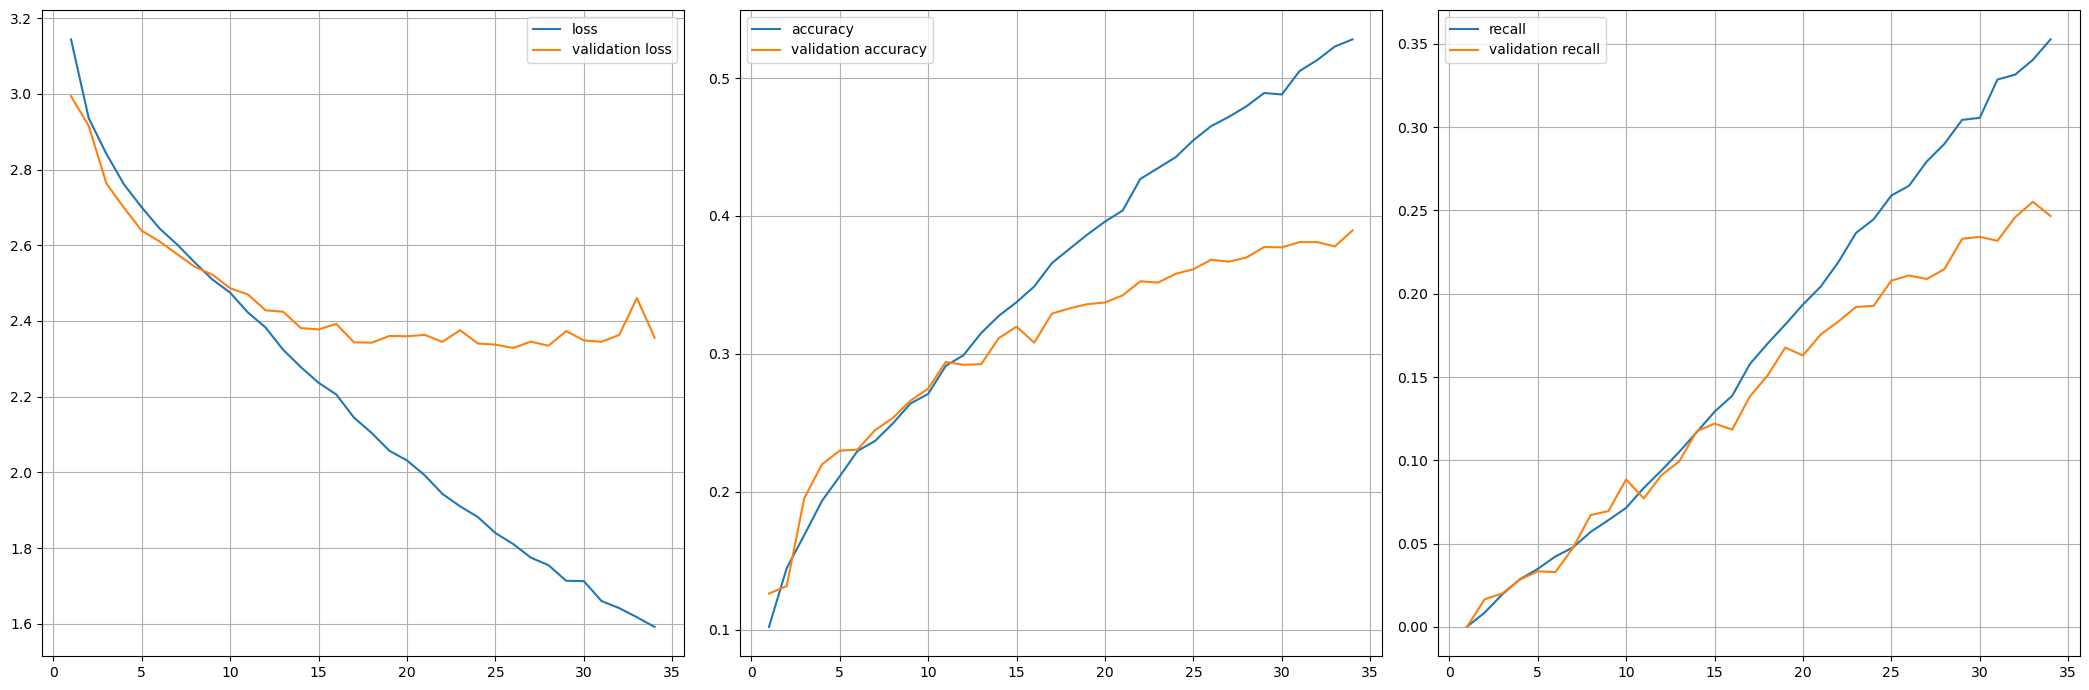

362/362 [==============================] - 39s 107ms/step - loss: 1.5916 - accuracy: 0.5280 - recall: 0.3527 - val_loss: 2.3561 - val_accuracy: 0.3895 - val_recall: 0.2467


In [67]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(8, 5, (1, 1), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  # layers.MaxPooling2D((3, 3)),
  layers.Conv2D(8, 5, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  layers.Conv2D(12, 5, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  layers.Conv2D(12, 5, (1, 1), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  # layers.Conv2D(36, 3, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  layers.MaxPooling2D((3, 3)),
  layers.Flatten(),
  layers.Dropout(0.35),
  layers.Dense(32 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  layers.Dropout(0.35),
  layers.Dense(16 * num_classes, activation='relu'),
  layers.Dropout(0.35),
  layers.Dense(8 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  layers.Dropout(0.35),
  layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.0005),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[
    'accuracy', 
    keras.metrics.Recall(thresholds=0.5, class_id=None, name='recall')
])

fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  callbacks=[
    tensorboard_callback, 
    PlotLearning(val=True),
    early_stopping_callback
    ]
)

In [68]:
model.evaluate(val_ds, callbacks=[tensorboard_callback])

97/97 [==============================] - 8s 74ms/step - loss: 2.3732 - accuracy: 0.3775 - recall: 0.2330


[2.3732495307922363, 0.37748345732688904, 0.23297066986560822]

In [69]:
images = []
labels = []

for x, y in train_ds.unbatch().take(1150):
    images.append(x)
    labels.append(np.argmax(y).item())

In [70]:
model.save('./models/cnn-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.keras')

In [71]:
test = np.array(images)

In [72]:
y_pred = (model.predict(test)).argmax(axis=1)

36/36 [==============================] - 1s 13ms/step


In [73]:
y_pred

array([ 1,  7, 10, ..., 18,  5,  5])

In [74]:
print(labels)

[1, 7, 10, 1, 1, 12, 14, 10, 18, 20, 18, 10, 6, 1, 2, 15, 8, 22, 13, 14, 11, 8, 21, 8, 8, 3, 0, 18, 17, 0, 1, 11, 17, 9, 11, 22, 17, 11, 17, 22, 4, 5, 5, 17, 22, 0, 21, 22, 9, 21, 13, 8, 2, 11, 8, 17, 15, 8, 17, 5, 11, 6, 21, 11, 3, 18, 11, 22, 22, 0, 18, 5, 17, 22, 11, 10, 8, 6, 11, 1, 1, 7, 6, 7, 1, 18, 5, 8, 10, 10, 3, 8, 18, 4, 10, 21, 5, 20, 10, 14, 15, 6, 7, 5, 21, 17, 18, 8, 10, 7, 14, 11, 3, 1, 9, 16, 5, 11, 10, 13, 8, 16, 8, 11, 10, 3, 20, 13, 6, 17, 0, 11, 10, 17, 5, 1, 1, 11, 8, 0, 22, 14, 5, 5, 7, 22, 22, 1, 8, 0, 9, 22, 8, 17, 4, 5, 13, 3, 3, 8, 15, 14, 6, 8, 8, 3, 19, 4, 0, 15, 5, 20, 8, 17, 8, 13, 1, 1, 5, 5, 22, 12, 4, 22, 10, 17, 15, 11, 15, 9, 0, 8, 15, 20, 8, 15, 22, 16, 2, 4, 21, 5, 21, 5, 20, 9, 21, 10, 20, 10, 2, 1, 15, 8, 0, 9, 1, 9, 15, 20, 8, 12, 18, 15, 13, 8, 15, 17, 5, 3, 15, 20, 3, 12, 0, 13, 5, 1, 15, 14, 7, 17, 13, 13, 17, 10, 4, 5, 10, 11, 0, 0, 5, 6, 8, 10, 8, 11, 1, 0, 11, 10, 0, 22, 9, 13, 5, 8, 10, 17, 18, 15, 8, 17, 8, 15, 1, 1, 1, 5, 12, 18, 0, 5, 

In [75]:
from sklearn.metrics import confusion_matrix, classification_report
print("==============TEST RESULTS============")
# print('Confusion Matrix')
# print(confusion_matrix(labels, y_pred))
print('\nClassification Report')
print(classification_report(labels, y_pred, target_names=val_ds.class_names))

==============TEST RESULTS============

Classification Report
                                               precision    recall  f1-score   support

                             Acne, or Rosacea       0.58      0.75      0.65        60
Actinic Keratosis, or other Malignant Lesions       0.72      0.64      0.68        77
             Alopecia, or other Hair Diseases       0.51      0.90      0.65        20
                            Atopic Dermatitis       0.57      0.29      0.38        42
                         Bacterial Infections       0.43      0.17      0.24        18
                                Benign Tumors       0.43      0.82      0.57        98
                              Bullous Disease       0.66      0.68      0.67        31
                   Connective Tissue Diseases       0.89      0.50      0.64        32
                                       Eczema       0.51      0.77      0.61        84
                 Exanthems, or Drug Eruptions       0.58      0.45 

In [76]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_68 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 conv2d_69 (Conv2D)          (None, 124, 124, 8)       1608      
                                                                 
 conv2d_70 (Conv2D)          (None, 40, 40, 12)        2412      
                                                                 
 conv2d_71 (Conv2D)          (None, 36, 36, 12)        3612      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 12, 12, 12)        0         
 ng2D)                                                           
                                                     

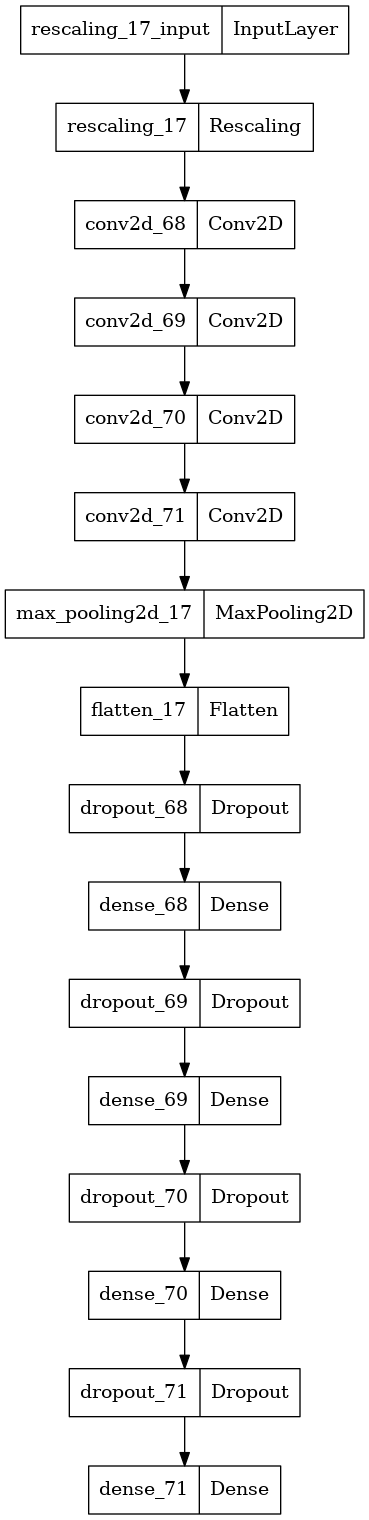

In [77]:
plot_model(model)

In [78]:
lmao = model.history

<Figure size 640x480 with 0 Axes>

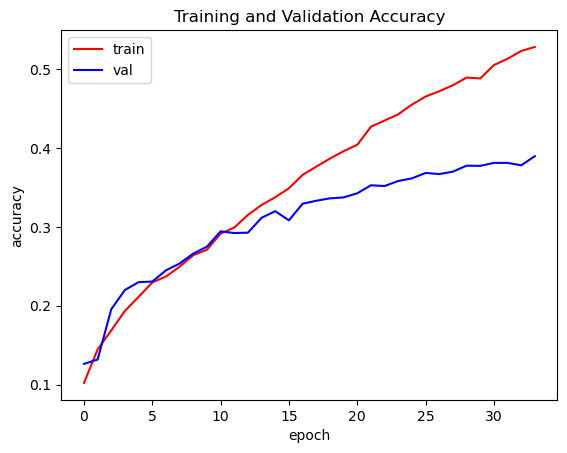

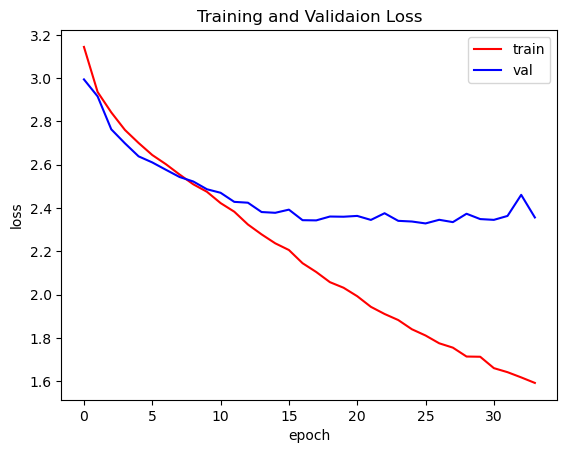

<Figure size 640x480 with 0 Axes>

In [79]:
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.title('Training and Validaion Loss')
plt.figure()

In [81]:
# model.save('./models/BEST-cnn.keras')